In [1]:
import sys
sys.path.append('..')

In [17]:
from tqdm import tqdm
import pandas as pd

In [2]:
from curry.loader import Loader

In [3]:
loader = Loader()

In [58]:
leifi = loader.simple()

In [50]:
leifi.shape

(11667, 7)

In [5]:
leifi.grundwissen_url.nunique()

539

In [6]:
counts_per_state = leifi.land.value_counts().to_frame()
counts_per_state.index = [l.replace('-', ' ').capitalize() for l in counts_per_state.index]
counts_per_state = counts_per_state.reset_index().\
    rename(columns = {'index': 'State', 'land': 'Lesson Count'})
# print(counts_per_state.to_latex())

In [7]:
content_by_url = leifi.groupby('grundwissen_url').content.first()

In [8]:
from curry.clean import Cleaner

In [9]:
cleaner = Cleaner('')

In [12]:
cleaned_contents = [cleaner.clean(c) for c in tqdm(content_by_url)]

100%|███████████████████████████████| 539/539 [02:08<00:00,  4.18it/s]


<AxesSubplot:>

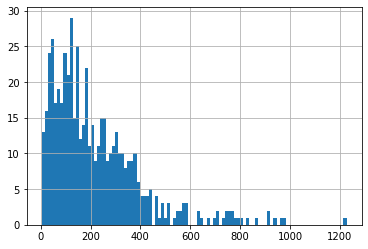

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
tokenizer = vec.build_tokenizer()
word_counts = pd.Series(
    [len(tokenizer(c)) for c in cleaned_contents],
    index=content_by_url.index)
word_counts.hist(bins=100)

In [43]:
word_counts.min(), word_counts.median(), word_counts.max()

(6, 174.0, 1227)

In [59]:
leifi = leifi[
    leifi.grundwissen_url.isin(word_counts[word_counts > 25].index)
]

In [61]:
leifi.shape

(11198, 7)

In [81]:
from scipy.stats import chisquare

In [82]:
chisquare(dice['observed'], dice['expected']) 

NameError: name 'dice' is not defined

In [84]:
v_counts = leifi.klass.value_counts().copy()

In [ ]:
expected = v_counts.copy() = v_counts.mean()

In [80]:
def agg_land(land_df):
    grade_dist = land_df.klass.value_counts()
    compare = pd.Dataframe( )
    return pd.Series({
        'Lowest Grade': land_df.klass.min(),
        'Highest Grade': land_df.klass.max(),
        '# Lessons': land_df.grundwissen_url.nunique(),
        'var': land_df.klass.std()
    })

summary = leifi.groupby('land').apply(agg_land)
summary

,Lowest Grade,Highest Grade,# Lessons,var
land,,,,
baden-wuerttemberg,5.0,12.0,435.0,1.878185
bayern,5.0,12.0,422.0,1.912044
berlin,5.0,12.0,460.0,2.163176
brandenburg,5.0,12.0,409.0,1.741013
bremen,5.0,12.0,396.0,1.886119
hamburg,5.0,12.0,407.0,2.077840
hessen,7.0,13.0,474.0,2.210274
mecklenburg-vorpommern,6.0,12.0,398.0,2.011261
niedersachsen,5.0,13.0,368.0,2.433768


In [77]:
print(summary.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Lowest Grade &  Highest Grade \\
land                   &               &                \\
\midrule
baden-wuerttemberg     &             5 &             12 \\
bayern                 &             5 &             12 \\
berlin                 &             5 &             12 \\
brandenburg            &             5 &             12 \\
bremen                 &             5 &             12 \\
hamburg                &             5 &             12 \\
hessen                 &             7 &             13 \\
mecklenburg-vorpommern &             6 &             12 \\
niedersachsen          &             5 &             13 \\
nordrhein-westfalen    &             5 &             12 \\
rheinland-pfalz        &             5 &             13 \\
saarland               &             7 &             12 \\
sachsen                &             6 &             12 \\
sachsen-anhalt         &             6 &             12 \\
schleswig-holstein     &             

In [87]:
from curry.model import Trainer

In [88]:
trainer = Trainer('../data/')

In [94]:
results = []
for vec_type in []:
    for land in leifi.land.unique():
        res, features = trainer.train_score(dict(
            land=land,
            name='xgbClassifier', 
            vec_type='kw',
            args=[
                10,
                leifi[leifi.land==land].klass.nunique()
            ]
        ))

INFO:root:train_score: {'land': 'berlin', 'name': 'xgbClassifier', 'vec_type': 'kw', 'args': [10, 8]}


({'confusion_matrix': array([[ 4,  0, 14,  6, 52, 33, 14,  6],
         [ 4,  0, 14,  6, 52, 33, 14,  6],
         [ 8,  0, 14,  8, 36, 26,  7, 10],
         [ 7,  0, 18,  5, 39, 31,  7, 10],
         [43,  0, 22, 21, 45, 27, 50, 12],
         [42,  0, 22, 21, 46, 27, 50, 12],
         [ 2,  0,  1,  3, 58, 32, 15,  6],
         [ 2,  0,  3,  7, 40, 20,  7, 43]]),
  'accuracy': 0.1316075725689727},
 ['Blick',
  'Energie',
  'Körper',
  'Volumen',
  'Grundwissen',
  'Atmosphäre',
  'Licht',
  'Temperatur',
  'Volumenänderung',
  'Flaschenzug',
  'Elektronen',
  'Bewegung',
  'Wärmetransport',
  'Hebel',
  'Einheiten',
  'Bauteile',
  'Mond',
  'Animation in Abb',
  'Induktion',
  'Abb',
  'Animation',
  'Physik',
  'Wichtigste',
  'Körpers',
  'bzw',
  'Schallwelle',
  'Strom',
  'Druck',
  'Sonne',
  'Aufbau',
  'Kraft',
  'Wärmestrahlung',
  'Welle',
  'Kreisbewegung',
  'Spezifische',
  'Widerstand',
  'Gegenstand',
  'Aufgabe',
  'Linse',
  'Atom',
  'Ladung',
  'Bild',
  'Schwingung